In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from generate_movies import runlength_decode

# Abstract


# Introduction
The class of problems of Cellular Automata was introduced in the 20th century by some mathematicians. Since CA represents the evolution over time of a population, there is no limit to the number of dimensions in the problem. However, for the sake of simplicity, this work is intended for bi-dimensional and finite regions. Every region is hence considered as a rectangular grid of $N$ rows and $M$ columns, named board. The squares of the board are called cells.

Like every automaton, CA problems are defined by a finite set of states for each cell in the grid. The time is discrete and, given a configuration, a set of rules determines the configuration of the following time step. These rules are constant over time and identical for all the cells in the board.

## Evolution rules
The rules that determine the update of a cell are functions of its neighbourhood. In this framework, the neighbourhood is limited to the Moore neighbourhood (see Figure \ref{fig:Moore_neighbourhood}). Hence, given $\mathbb{S}$ the set of possible states, every rule is a function $f: \mathbb{S}^9 \rightarrow \mathbb{S}$.

![alt text](images/Moore.png "Title")

The user can define custom rules based on every subset of the Moore neighbourhood, by just ignoring some cells. For example, the VonNeumann neighbourhood is obtainable by a simple restriction of the rules to the domain $\mathbb{S}^5$.

![alt text](images/vonNeumann.png "Title")

The edges of the board are critical zones, since the neighbourhoods of their cells are not completely defined. In this framework, the 2D-support is considered as toroidal: the last row (column) is considered
adjacent to the first row (column).

![alt text](images/toroid.png "Title")

The most famous version of CA is the Conway's Game of Life. Every cell has two possible states: dead or alive. The state transitions are based on its 8 Moore neighbours:

- Any alive cell dies by underpopulation it it has 1 or 0 alive neighbours.
- Any alive cell survives if it has 2 or 3 live neighbours.
- Any alive cell dies by overpopulation if it has 4 or more alive neighbours.
- Any dead cell becomes alive by reproduction, if it has 3 alive neighbours. Otherwise, it remains dead.

By introducing a stochastic probability of cell death, [Yaroslavsky L.](https://arxiv.org/abs/1304.8104) identified the formation of maze-like structures with chaotic dislocations. Our goal is to evaluate the impact of the stochastic hyperparameters on the stability and the density of these structures.

Moreover, with a particular set of rules on a 1-dimensional grid, [Monetti and Albano](https://www.sciencedirect.com/science/article/pii/S0378437196003160) observed that,defined several possible asymptotic states of the population:
- Extinction
- Overcrowding
- Chaotic life
- Frozen life

## Problem Formulation

We consider a 2-dimensional squared board with side N = 100. 

To relate our simulations with the states introduced by Monetti and Albano, we introduce two quantitative metrics:

- Density, defined as $d_t = \frac{\#alive_t}{\#alive_t + \#dead_t}$

- Stability, defined as $s_t = 1 - \frac{\#updated_t}{N^2}$. #updated_t counts the cells which changed state from $t-1$ to $t$.

Since the literature focuses on the asymptotic behaviour, during our analysis we evaluate the average Density and Stability over the last 100 epochs of simulations of 500 epochs.

A key component of the simulation is the configuration at $t_0$. In our case, we initialize the board with a [Gosper Glider Gun](https://conwaylife.com/wiki/Gosper_glider_gun).


## The framework

Our framework for defining rules and running simulations is written in C++. The code is located in './code'.

Some additional python scripts and notebooks are included in this repo to generate the videos of the simulations and plot some metrics. In order to save space, the simulations run with c++ are stored into txt files (in folder './results') through RunLenght binary encoding.

The basic usage of this framework is the following:
- compile and build c++ code with CMake through the script './maker.sh'
- run simulations and generate plots through the script './run_simulations.sh'

# Rules implemented

## Stochastic Version
The stochastic version considers the 8 Moore neighbours and follows this set of rules:
- Any alive cell with 1 or 0 alive neighbours (underpopulation) or 4 or more alive neighbours (overpopulation) dies with probability $p_{death}$.
- Any alive cell survives if it has 2 or 3 alive neighbours.
- Any dead cell becomes alive by reproduction if it has 3 alive neighbours or, with probability $p_{birth}$, if it has 2 alive neighbours. Otherwise it remains dead.

## Von-Neumann Version
The VonNeumann Version, inspired by the 1-dimensional rules defined by Monetti and Albano, considers the 4 Von-Neumann neighbours and the following set of rules:

- Any alive cell with 2 or 3 alive neighbours (overpopulation) dies with probability $p_{death}$.
- Any alive cell survives if it has 0 or 1 alive neighbours.
- Any dead cell becomes alive by reproduction if it has 2 alive neighbours or, with probability $p_{birth}$, if it has 1 alive neighbour. Otherwise it remains dead.

# Software assessment
The framework is assessed by running a simulation with the Stochastic Rule, setting $p_{death} = 1$ and $p_{birth} = 0$. The evolution of the system correclty follows the expected behaviour of the Gosper Glider Gun.

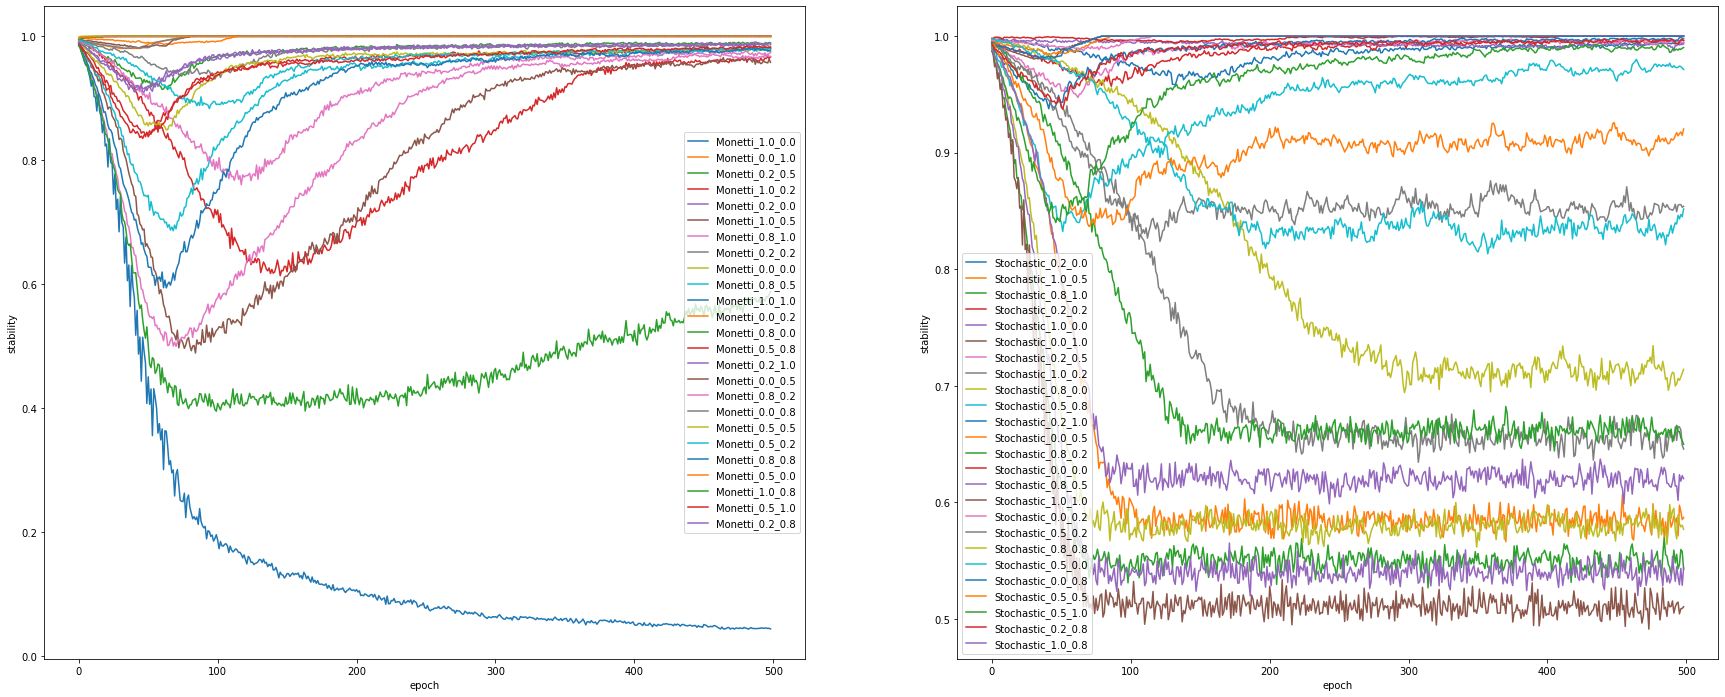

In [49]:
df = pd.DataFrame(columns = ['rule', 'p_{death}', 'p_{birth}', 'density', 'stability'])
final_epochs = 100
rules = ['VonNeumann', 'Stochastic']
plots_folder = 'stability_plots'

N = 100
fig, axs = plt.subplots(1, 2, figsize=(30,12))

for plot_index, rule in enumerate(rules):
    filenames = [x[:-4] for x in os.listdir(os.path.join('results', rule))]
    for filename in filenames:
        grids = []
        with open(os.path.join('results', rule, filename+'.txt')) as file:
            for line in file:
                grids.append(runlength_decode([int(number) for number in line.split(', ')], N).ravel())
        grids = np.stack(grids, axis=0)
        stability_in_time = 1 - np.abs(np.diff(grids, axis=0)).mean(axis=1)
        axs[plot_index].plot(stability_in_time, label=filename)
        _, p_d, p_b = filename.split('_')
        d = grids[-final_epochs:, :].mean()
        s = stability_in_time[-final_epochs:].mean()
        sim = {'rule': rule, 'p_{death}': p_d, 'p_{birth}': p_b, 'density': d, 'stability': s}
        df = df.append(sim, ignore_index=True) 
    axs[plot_index].set_xlabel('epoch')
    axs[plot_index].set_ylabel('stability')
    axs[plot_index].legend()
plt.show()

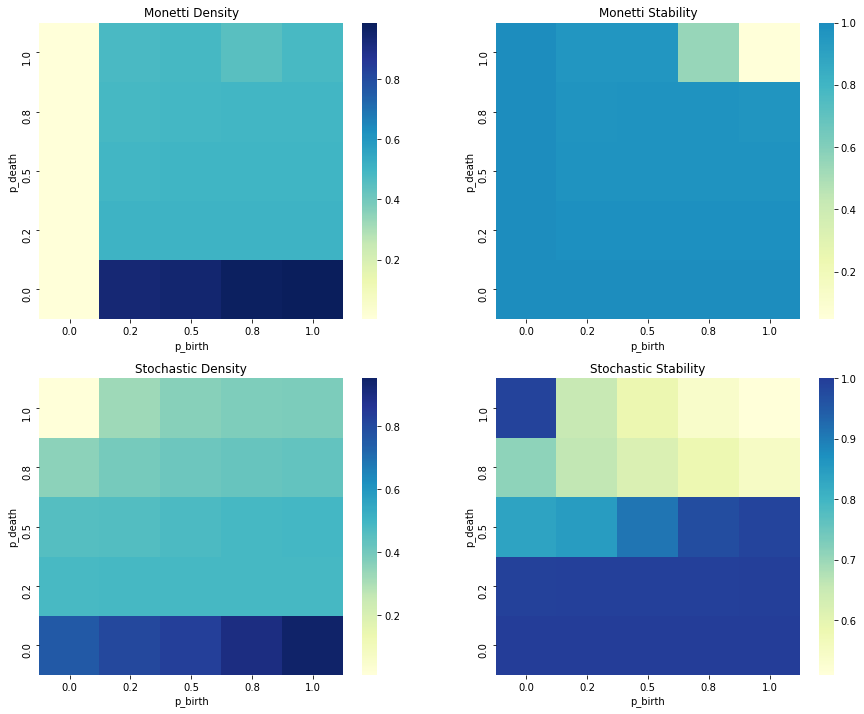

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))
summary_axes = axes.ravel()
sns.heatmap(df[df.rule.eq('VonNeumann')].pivot("p_{death}", "p_{birth}", "density"), ax=summary_axes[0], center=0.5, cmap="YlGnBu")
sns.heatmap(df[df.rule.eq('VonNeumann')].pivot("p_{death}", "p_{birth}", "stability"), ax=summary_axes[1], center=0.8, cmap="YlGnBu")
sns.heatmap(df[df.rule.eq('Stochastic')].pivot("p_{death}", "p_{birth}", "density"), ax=summary_axes[2], center=0.5, cmap="YlGnBu")
sns.heatmap(df[df.rule.eq('Stochastic')].pivot("p_{death}", "p_{birth}", "stability"), ax=summary_axes[3], center=0.8, cmap="YlGnBu")

for a in summary_axes:
    a.invert_yaxis()

summary_axes[0].set_title('VonNeumann Density')
summary_axes[1].set_title('VonNeumann Stability')
summary_axes[2].set_title('Stochastic Density')
summary_axes[3].set_title('Stochastic Stability')

plt.show()